## Bank Marketing Campaign
## Specialization: Data Science
## Data Glacier Virtual Internship
### Presented by the Greeks
### Galanakis Michalis, Konioris Aggelos, Moysiadis Giorgos

#### At first, we import all the libraries that will be utilized

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# for reproducibility
SEED = 0

#### Before starting our model buliding analysis, we run the code from previous assignment for handling missing values

In [2]:
bank_additional_full = pd.read_csv("bank-additional-full.csv", delimiter = ';')
df = bank_additional_full 
df.replace('unknown', np.nan, inplace = True)
df['loan'].fillna(df['loan'].value_counts().index[0], inplace = True)
df['marital'].fillna(df['marital'].value_counts().index[0], inplace = True)
df['default'].fillna(df['default'].value_counts().index[0], inplace = True)

def na_randomfill(function):
    na = pd.isnull(function)   
    number_null = na.sum()        
    if number_null == 0:
        return function             
    fill_values = function[~na].sample(n = number_null, replace = True, random_state = 0)
    fill_values.index = function.index[na]
    return function.fillna(fill_values)

df = df.apply(na_randomfill)

#### This step provides the transformation of the qualitative variables into quantitative, so we can use them in our modebls

In [3]:
obj_column = df.dtypes[df.dtypes == 'object'].index

labelencoder_X = LabelEncoder()
for column in obj_column:
    df[column] = labelencoder_X.fit_transform(df[column])

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,1,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,1,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


#### Split our data in to train and test sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1), df['y'], test_size = .2, 
                                                    random_state = SEED, stratify = df['y'])

#### Rescale our data from their default range to 0-1 range.

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Before we procced into the final step of our project we use boosting in order to see which features should be utilized in our model

In [6]:
boost = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, max_depth = 4, random_state = 1)
boost.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500,
                           random_state=1)

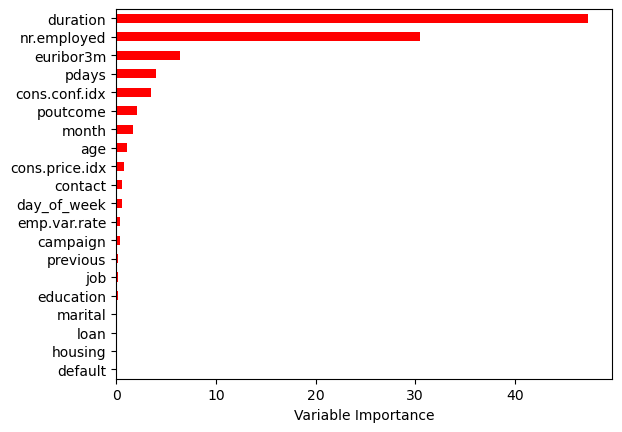

In [7]:
X = df.drop(['y'], axis = 1)
feature_importance = boost.feature_importances_ * 100
rel_imp = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)
rel_imp.T.plot(kind = 'barh', color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.show()

#### As we can see, the most important features are duration, nr.employed, euribor3m, pdays and cons.conf.idx
#### Finally, we apply the XGboost model since it provided the best performance in the previous assignment

In [8]:
dframe = df[['duration', 'nr.employed', 'euribor3m', 'pdays', 'cons.conf.idx', 'y']]
X = dframe.drop(['y'], axis = 1)
y = dframe['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = SEED)

xgb = XGBClassifier(eval_metric = 'mlogloss')
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print('Accuracy:', round(xgb.score(X_test, y_test), 2),)
print('F1_score:', round(f1_score(y_test, preds), 2),)
print('Cross_val_score:', round(cross_val_score(xgb, X_test, y_test, cv = 5).mean(), 2),)
print('Recall:', round(recall_score(y_test, preds), 2),)
cm = confusion_matrix(y_test, preds)
print(f"Confusion Matrix:\n {cm}")

Accuracy: 0.92
F1_score: 0.62
Cross_val_score: 0.91
Recall: 0.57
Confusion Matrix:
 [[7057  262]
 [ 392  527]]


#### Despite applying boosting on our best model, the performance of XGboost does not improve significantly. We han an increase from 0.01 to 0.03 in each value.

### Nevertheless, it has provided us satisfactory results. It’s a good model for the bank to try and reach out to new customers.